# computation of the line-of-sight velocity dispersion of a stellar system

This is a standard spherical Jeans analysis, that proceeds as follows :
* choose a 2D surface brightness profile $I(R)$ for the stellar system. This defines the 3D stellar density $\nu(r)$ as well.
* Choose a sDM density rho(r), which also yields its integral mass within radius $s$ $M(s)$
* Then apply the following two equations to obtain $\sigma^2_{los}$:
\begin{align}
\sigma^2_{los} &= \frac{2}{I(R)}\int_R^\infty \left(1-\beta\frac{R^2}{r^2}\right)\nu(r)\sigma^2(r)\frac{r{\rm d}r}{\sqrt{r^2-R^2}}\\
\nu(r)\sigma^2(r) &= \int_r^\infty \left(\frac{s}{r}\right)^{2\beta}\nu(s)\frac{GM(s)}{s^2}{\rm d}s
\end{align}


A common choice for the stellar density and surface brightness is the so-called Plummer profile :
\begin{align}
\nu(r) &= \frac{\rho_h}{\left(1+(\frac{r}{r_h})^2\right)^{5/2}} \\
I(R) &= \frac{4}{3}\frac{\rho_h r_h}{\left(1+(\frac{r}{r_h})^2\right)^2}
\end{align}

In [4]:
def nu(r,rh,rhoh):
    return rhoh * (1 + (r/rh)**2)**(-5./2.)
def I(R,rh,rhoh):
    return 4./3. * rh*rhoh/(1+(r/rh)**2)**2

For the spherical Dark Matter profile, we will use the generalized NFW profile :
\begin{equation}
\rho(r) = \frac{\rho_0}{\left(\frac{r}{r_0}\right)^a\left(1+(\frac{r}{r_0})^b\right)^\frac{c-a}{b}}
\end{equation}
with the standard NFW profile corresponding to $(a,b,c)=(1,1,3)$.
La masse enclose peut être calculée analytiquement :
\begin{align}
M(s) &= \int_0^s 4\pi r^2 \rho(r){\rm d}r \\
     &= 4\pi\rho_0 r_0^3 \int_0^{s/r_0} \frac{x^{2-a}}{(1+x^b)^\frac{c-a}{b}} {\rm d}x \\
     &= \frac{4\pi\rho_0 r_0^3}{(3 - a)} x^{3 - a}{}_2F_1\left[\frac{3 - a}{b}, \frac{-a + c}{b}, \frac{3 - a + b}{b}, -x^b\right]\quad x=\frac{s}{r_0}\\
     &= \mu_0\;\mu(x)
\end{align}

This results in :
\begin{align}
\nu(r)\sigma^2(r) &= G\mu_0\;r^{-2\beta}\;\int_r^\infty s^{2\beta}\nu(s)\frac{\mu(s/r_0)}{s^2}{\rm d}s\\
&= G\mu_0\rho_h\;r^{-2\beta}\;\int_r^\infty \frac{s^{2\beta}}{\left(1+(\frac{r}{r_h})^2\right)^{5/2}}\frac{\mu(s/r_0)}{s^2}{\rm d}s\\
&= G\mu_0\rho_hr_h^{-1}\;(\frac{r}{r_h})^{2\beta}\;\int_\frac{r}{r_h}^\infty \frac{y^{2\beta-2}}{\left(1+y^2\right)^{5/2}}\mu(y\,r_h/r_0){\rm d}y \quad\quad y=r/r_h\\
\sigma^2_{los}(R) &= \frac{2G\mu_0\rho_hr_h^{-1}}{I(R)}\int_R^\infty \left(1-\beta\frac{R^2}{r^2}\right)\frac{r{\rm d}r}{\sqrt{r^2-R^2}}(\frac{r}{r_h})^{2\beta}\;\int_\frac{r}{r_h}^\infty \frac{y^{2\beta-2}}{\left(1+y^2\right)^{5/2}}\mu(y\,r_h/r_0){\rm d}y\\
&= \frac{2G\mu_0\rho_h}{I(R)}\left(\frac{R}{r_h}\right)^{2\beta+1}\int_1^\infty \left(1-\frac{\beta}{z^2}\right)\frac{z^{2\beta+1}{\rm d}z}{\sqrt{z^2-1}}\;\int_\frac{zR}{r_h}^\infty \frac{y^{2\beta-2}}{\left(1+y^2\right)^{5/2}}\mu(y\,r_h/r_0){\rm d}y
\end{align}

We can note the following :
* $\rho_h/I(R)$ is independent of $\rho_h$, which thus can be set arbitrarily to 1;
* if we neglect the dependency on $r_0$ of the double integral for a moment, we can immediately see that $\rho_0$ and $r_0$ are quite degenerate, as they appear in $\sigma_{los}$ as a product $\rho_0r_0^3$. This fact also justifies that one may be better off using the parameter $M_0=\rho_0r_0^3$ instead of $\rho_0$;
* a minimization procedure will be penalized if it requires recomputation of the double integral each time it changes $\rho_0$ only. The easiest way out in case of a Likelihood formulation is to use a profiled likelihood method, where $\rho_0$ is fitted (fast evaluations) while $r_s$ is scanned over (slow double integrand computation, but performed only once per $r_s$ value);
* units are carried over to $\sigma^2_{los}$ by the product $GM_0/r_h$, which usually is to be defined in km$^2$s$^{-2}$, while $r_h$ (together with $r_0$ and $R$) is given in kpc. Donc :
\begin{equation}
\frac{GM_0[\rm kg]}{r_h[\rm m]}\; {\rm m^2}{\rm s}^{-2} = 4.3\,10^{-6} \frac{M[M_\odot]}{r_h[\rm kpc]} \; {\rm km^2}{\rm s}^{-2} 
\end{equation}

which means that a galaxy with mass $10^6-10^8$ solar masses will result in a line-of-sight squared velocity dispersion of order $1-10^2 \;{\rm km^2}{\rm s}^{-2} $


In [32]:
from scipy import special
import numpy as np
from matplotlib import pylab as plt
from scipy.integrate import quad,quadrature
%matplotlib inline

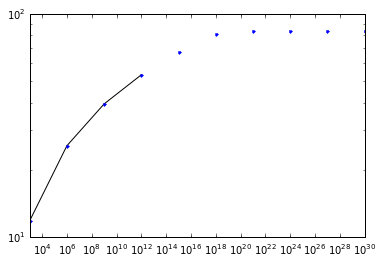

In [50]:
# Contained mass of the DM halo : generalized NFW
a=1.
b=1.
c=3.
def mu(x):
    return x**(3.-a)*special.hyp2f1((3.-a)/b, (c-a)/b, (-a+b+3.)/b,-x**b)

def dmass(x,a,b,c):
    return pow( x, 2.-a)/pow(1. + pow(x,b), (c-a)/b )

def get_M(x):
    return quad(dmass, 0., x, args=(a,b,c))[0]

x = np.logspace(3, 30, 10)
yy = [(3.-a)*get_M(xx) for xx in x]
plt.loglog(x,mu(x),'k')
plt.loglog(x,yy, '.')
# The special function breaks out at 10^14, before the quad integration start showing issues

In [51]:
beta=-0.005
def integrand1(y, alpha):
    result = nu(y, 1, 1)*mu(y*alpha)/y**(2.-2.*beta)
    return result

def integral1(ymin,alpha):
    res,err = quad(integrand1, r, +np.inf, args=(alpha) )
    return res, err


